# HW 2.2 - Email Spam Detection [50 + 5 points]

   * Dataset and updates: https://gist.github.com/emaadmanzoor/aedddf2b69e54a9a2fd320230bbb692a
   * Contact TA: Rashmi Raghunandan (rashmir[at]andrew.cmu.edu)

*Please only attempt bonus point problems after completing the non-bonus questions.*

## Get the data

   * Unzip the data into the same folder as the notebook.
   * There are 3 folders in the Dataset folder:
   * The folder "ham" contains all training non-spam email.
   * The folder "spam" contains all training spam email.
   * The folder "testing" is meant for the test data.
   * The folder "evaluation-testing" is meant for you to make predicitons without knowing the actual labels (this should be empty right now).

## Find the number of emails present in the ham and spam folders [5 points]
 
Do you find something unexpected from the distribution (e.g., whether the dataset is balanced)? Will this be problematic in training the model? If so, could you give some idea about how to address it and explain why your idea should work?

In [1]:
import glob
ham_emails = glob.glob('./Hw2-data/ham/*.txt')
print("Number of emails present in the ham:", len(ham_emails))
spam_emails = glob.glob('./Hw2-data/spam/*.txt')
print("Number of emails present in the spam:", len(spam_emails))

Number of emails present in the ham: 1488
Number of emails present in the spam: 3659


**The number of emails present in the spam folder almost twice as the number of emails present in the ham, which means the training dataset is unbalanced. This will be problematic in training the model, and caused classification difficulty.Since spam is the amlost twice the ham, we can treat the spam as another classification problem and divide it into two classes.**

## Create a list of words [2.5 points]
 
Below is a function that returns a list of words present in a file given a fileName. In the comments, you can find numbers from (1)- (4). In your own words, explain the purpose of these lines of code. 

In [2]:
from collections import Counter
import re
import pandas as pd
import string

def makeWordList(path):
    
    with open(path, encoding ='ISO-8859-1') as f:
        corpus_text = f.read()

    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")  # --(1) 
    
    text = re.sub(r'\S*\d\S*','',corpus_text) # -- (2) 
    text = re.sub(r'[^\w\s]','',text)         # -- (3) 
    
    text = text.lower().split()           # -- (4)      
    
    li = []
    for token in text:
        li.append(token)

    return li

**(1) remove all the punctuation strings  
(2) remove all the digital number from the corpus_text    
(3) remove all the non-word characters from the text  
(4) change all the text to lower case and split the text into words **
 

## Create two list of lists by calling the above function on every file of the spam and ham folders. Name the two lists ham and spam [2.5 points]

The lengths of these lists should match that in your first question.

For eg. Your spam list contatins multiple inner lists. Each of these inner lists have the words in that email. 

In [3]:
ham = [makeWordList(file) for file in ham_emails]
print("Number of emails present in the ham:", len(ham))
spam = [makeWordList(file) for file in spam_emails]
print("Number of emails present in the spam:", len(spam))

Number of emails present in the ham: 1488
Number of emails present in the spam: 3659


## Feature Extraction [7.5 points]

We will now use the list of  you created above to create a feature matrix.
Our feature  matrix is a binary feature matrix which indicates if a word is present in an email.
The above function does not acount for duplicate words. In your feature set, you need to ensure that every word occurs only once. Below is some code to help you get the list of unique words:

all_words = [j for i in li for j in i]
all_words = list(set(all_words))

   - (i) Some of these words might be stop words. To help you remove them, a stopword.txt file has been provided.
   - (ii) Using all the words will take a long time to run. Take any random 1000 words for your implementation.


Write a function to create and return the feature matrix.





In [4]:
import random
from sklearn.feature_extraction.text import CountVectorizer

stopwords = makeWordList('./Hw2-data/stopwords.txt')
all_words_spam = [j for i in spam for j in i if j not in stopwords] 
all_words_ham = [j for i in ham for j in i if j not in stopwords] 
all_words = all_words_spam + all_words_ham
all_words = list(set(all_words))
num_words = 1000
random_words = random.sample(all_words, num_words)
tf_vectorizer = CountVectorizer(vocabulary=random_words,max_features=num_words,
                                stop_words=stopwords)

In [5]:
def makeFeatureMatrix(li):   
    email_words = []
    for i in range(len(li)):
        word_list = [word for word in li[i] if word in random_words]
        email_words.append(' '.join(list(set(word_list))))
        #print(len(email_words[i]))
    tf = tf_vectorizer.fit_transform(email_words)
    return tf.toarray()

## Training set [2.5 points]

First, we will need to create a training set. Till now we have worked with spam and ham seperately. We will merge the two to create a new list. Use the code:
training = spam + ham

Call the function from part d on training.
Create a lables vector y. y will be 0 for all ham and 1 for all spam.

In [6]:
import numpy as np
training = []
training = spam + ham
y = np.concatenate((np.ones(len(spam)),np.zeros(len(ham))), axis = 0) 
X = makeFeatureMatrix(training)

## Cross Validation [5 points]
Write a cross validation function. This function must input a classifier, the training Matrix, the label vector and number of folds.

The function must divide the training data into folds and treat each fold as test data and return the average weighted F1-score obtained by the different folds.

In [7]:
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
#sklearn.metrics.f1_score(y_true, y_pred, labels=None, pos_label=1, average=’binary’, sample_weight=None)
def cross_validation(clf, X, y, n_folds):
    k_fold = KFold(n_folds)
    fold_scores = []
    for k, (train, val) in enumerate(k_fold.split(X, y)):
        clf.fit(X[train], y[train])     
        ypred = clf.predict(X[val])
        yval = y[val]
        #accuracy = np.sum(ypred==yval)/len(ypred)
        f_score_k = f1_score(yval, ypred)
        fold_scores.append(f_score_k)  
    f_score = np.average(fold_scores)#weights all equal to 1
    return f_score

## KNN [2.5 points]

KNearest Neighbour is a is a non-parametric method used for classification. 
Using the feature matrix and labels you created above, write code below to find the best K using cross validation. You must iterate over a range of possible k values and call the cross validation function you wrote in part h for each possible value of k. Find the k which gives you the best accuracy.

In [8]:
from sklearn.neighbors import KNeighborsClassifier
Ks = np.arange(5)+1
k_scores = []
for k in Ks:
    k_score = cross_validation(KNeighborsClassifier(n_neighbors=k), X, y, 5)
    print("K =", k, ":", k_score)
    k_scores.append(k_score)
best_score_idx = np.argmax(k_scores)
best_k = Ks[best_score_idx]
print("Best K: " + str(best_k) + " with score: " + str(k_scores[best_score_idx]))

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


K = 1 : 0.751510342835
K = 2 : 0.746722725828
K = 3 : 0.751187827375
K = 4 : 0.748651215867
K = 5 : 0.750369293328
Best K: 1 with score: 0.751510342835


## Feature matrix [5 points]

Create the feature matrix for the test set using the same steps as above.  Predict the classifier output after chosing the best k from above. Read the name of the files in the testing directory. If they end with spam, it is a spam file. If they end with ham, it is a ham file. Create the true prediction array.
Using the predicted and true values, create a confusion matrix.
Plot the ROC curve for FPR and report the AUC value.

Note: Some words from your test data may not have been present in the training data. There a multiple approaches to solving this problem. Clearly state your approach for dealing with this problem.  Report the weighted F1 score.

In [9]:
#read files in the testing folder
testing_emails = glob.glob('./Hw2-data/testing/*.txt')
testing_ham = []
testing_spam = []
# get the testing wordlists for ham and spam
for email in testing_emails:
    if email.endswith('ham.txt'):
        testing_ham.append(makeWordList(email))
    elif email.endswith('spam.txt'):
        testing_spam.append(makeWordList(email))
    else:
        print("Unrecognised file name.")

In [10]:
#get the testing word list
testing =[]
testing= testing_ham  + testing_spam


#Create a lables vector y_test（y_true）. y_test will be 0 for all ham and 1 for all spam
y_test = np.concatenate((np.zeros(len(testing_ham)),np.ones(len(testing_spam))), axis = 0) 

#get the feature matrix 
#Note: in the makeFeatureMatrix we filter the words only list in the random training data
X_test = makeFeatureMatrix(testing)

In [11]:
X_test.shape

(60, 1000)

In [12]:
# get the accuracy on test data

knn_clf = KNeighborsClassifier(n_neighbors=best_k)
knn_clf.fit(X, y)      
ypred = knn_clf.predict(X_test)
knn_f_score = f1_score(y_test, ypred)
print("F1-score on test data: " + str(knn_f_score))

F1-score on test data: 0.740740740741


In [13]:
from sklearn.metrics import confusion_matrix

#get confusion matrix
confusion_matrix(y_test, ypred, labels=None, sample_weight=None)
#tn, fp, fn, tp = confusion_matrix(y_true=y_test, y_pred=ypred, labels=None, sample_weight=None).ravel()

array([[ 9, 21],
       [ 0, 30]])

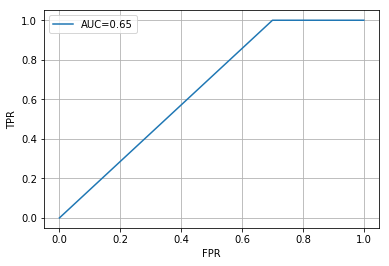

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, ypred, pos_label=1)
auc = np.trapz(tpr, fpr)
plt.plot(fpr, tpr, label="AUC=" + str(auc))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.grid()
plt.legend()
plt.show() 

## Bernoulli Naive Bayes [5 points]

Implement Bernoulli Naive Bayes classification. Perform Laplace smoothning. To find the best value for smoothening, performs the same steps as you did to find the best k. To help you, the grid to search over the best alpha is np.logspace(-2,10,5).
Predict the values on the testing data and create a confusion matrix. Plot the ROC curve for FPR and report the AUC value. Report the weighted F1 score.

In [15]:
from sklearn.naive_bayes import BernoulliNB

alphas = np.logspace(-2,10,5)
alpha_scores = []

for a in alphas:
    alpha_score = cross_validation(BernoulliNB(alpha=a), X, y, 5)
    print("alpha =", a, ":",alpha_score)
    alpha_scores.append(alpha_score)
best_score_idx = np.argmax(alpha_scores)
best_alpha = alphas[best_score_idx]
print("Best alpha: " + str(best_alpha) + " with score: " + str(alpha_scores[best_score_idx]))

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


alpha = 0.01 : 0.747294235306
alpha = 10.0 : 0.742447599005
alpha = 10000.0 : 0.742589118199
alpha = 10000000.0 : 0.742589118199
alpha = 10000000000.0 : 0.742589118199
Best alpha: 0.01 with score: 0.747294235306


In [16]:
nb_clf = BernoulliNB(alpha=best_alpha)
nb_clf.fit(X, y)  
nb_ypred = nb_clf.predict(X_test)

In [17]:
nb_f_score = f1_score(y_test, nb_ypred)
#accuracy = np.sum(ypred==y_test)/len(ypred)
print("F1-score on test data: " + str(nb_f_score))

F1-score on test data: 0.736842105263


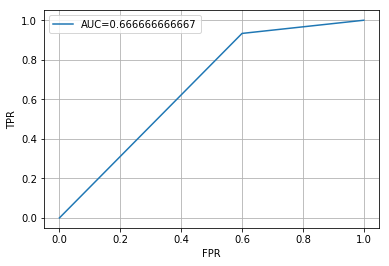

In [18]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, nb_ypred, pos_label=1)
auc = np.trapz(tpr, fpr)
plt.plot(fpr, tpr, label="AUC=" + str(auc))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.grid()
plt.legend()
plt.show() 

## SVM kernels [5 points]

Svm can be implemented with many kernels. Use any kernel of your choice. Select the best C using the same methods as you sued to select alpha and K. The range for c is 0.01 to 1000. You may use a step function if you wish.
Briefly explain the kernel you chose and which kind of data it works best on. Predict the values on the testing data and create a confusion matrix. Plot the ROC curve for FPR and report the AUC value.  Report the weighted F1 score.

In [19]:
from sklearn.svm import SVC

Cs = np.logspace(-2,3,10)
c_scores = []

for c in Cs:
    c_score = cross_validation(SVC(C=c), X, y,5)#use the default kernel=’rbf’, it is good for non-linear model
    print("C =", c, ":", c_score)
    c_scores.append(c_score)
best_score_idx = np.argmax(c_scores)
best_c = Cs[best_score_idx]
print("Best C: " + str(best_c) + " with score: " + str(c_scores[best_score_idx]))

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


C = 0.01 : 0.742589118199
C = 0.035938136638 : 0.742589118199
C = 0.129154966501 : 0.742589118199
C = 0.464158883361 : 0.742589118199
C = 1.6681005372 : 0.740352125449
C = 5.99484250319 : 0.750282911165
C = 21.5443469003 : 0.752296269858
C = 77.4263682681 : 0.754504687816
C = 278.255940221 : 0.753453688069
C = 1000.0 : 0.752816615943
Best C: 77.4263682681 with score: 0.754504687816


In [20]:
svm_clf = SVC(C=best_c)
svm_clf.fit(X, y)
svm_ypred = svm_clf.predict(X_test)

In [21]:
svm_f_score = f1_score(y_test, svm_ypred)
print("F1-score on test data: " + str(svm_f_score))

F1-score on test data: 0.716049382716


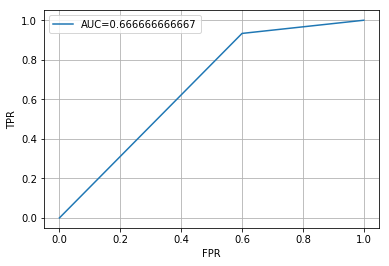

In [22]:
fpr, tpr, thresholds = roc_curve(y_test, nb_ypred, pos_label=1)
auc = np.trapz(tpr, fpr)
plt.plot(fpr, tpr, label="AUC=" + str(auc))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.grid()
plt.legend()
plt.show() 

## Compare the F1-values of the above three methods. Comment on the value of F1 Score and explain the differences. [2.5 points]

#################################################################################################   
**The F1-score of the above three methods on training set are all around 0.74/0.75, the higher of f1-score on testing data won't means the higher f1-scores on testing set based on my test. Classifier has a higher F1-score on training data but has a low F1-score on testing data, which may means the training model is over-fitting.**   #################################################################################################

## Custom method [5 points]

You can now use any classifier of your choice and/or change the feature matrix to imporove the accuracy. In fact, you are allowed to make changes to any of the steps till this point.
Predict the values on the testing data and create a confusion matrix. Plot the ROC curve for FPR and report the AUC value. 
Briefly explain your method (e.g., what features did you choose and why, how you selected the method to use).
To get full credit for this part, your f1-score must be at least 0.43.

**Important**: Do NOT make any code changes to the above code blocks. If you want to change any of those parts, please rewrite them in the box below (basically when grading we will run the above blocks first, and they should not use the custom code).

In [23]:
#The custom method I use here is random forest classifier,
#it use averaging to improve the predictive accuracy and control over-fitting
# To improve the testing speed, I still use the same features as above, 
#and which will give a comparison of the performance with the above three methods.

from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier()
#dt_clf = DecisionTreeClassifier()
f_score = cross_validation(rf_clf, X, y,5)
print("f1-score:", f_score)

f1-score: 0.750079526836


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


In [24]:
#predict on the testing data
rf_clf.fit(X, y)      
rf_ypred = rf_clf.predict(X_test)
rf_f_score = f1_score(y_test, rf_ypred)
print("F1-score on test data: " + str(rf_f_score))

F1-score on test data: 0.712328767123


In [25]:
#confusion matrix
confusion_matrix(y_test, rf_ypred, labels=None, sample_weight=None)

array([[13, 17],
       [ 4, 26]])

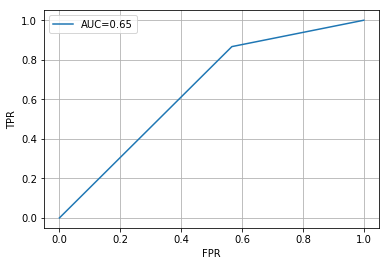

In [26]:
#Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, rf_ypred, pos_label=1)
auc = np.trapz(tpr, fpr)
plt.plot(fpr, tpr, label="AUC=" + str(auc))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.grid()
plt.legend()
plt.show() 

## BONUS [5 points]
Read the emails present in evaluation-testing. You must assume that the emails will be present in the same way as they were in the Testing folder.

Print your predictions for those emails. The top 3 performers will receive 5 more bonus points.
Note - These emails are not given to you right now, they are hidden. 

In [27]:
evaluation_emails = glob.glob('./Hw2-data/evaluation-testing/*.txt')

evaluation_ham = []
evaluation_spam = []
# get the testing wordlists for ham and spam
for email in evaluation_emails:
    if email.endswith('ham.txt'):
        evaluation_ham.append(makeWordList(email))
    elif email.endswith('spam.txt'):
        evaluation_spam.append(makeWordList(email))
    else:
        print("Unrecognised file name.")

In [28]:
evaluation = evaluation_ham + evaluation_spam
X_eval = makeFeatureMatrix(evaluation)
y_eval = np.concatenate((np.zeros(len(evaluation_ham)),np.ones(len(evaluation_spam))), axis = 0)

In [29]:
dt_eval_clf = RandomForestClassifier()
dt_eval_clf.fit(X, y)
dt_eval_ypred = dt_eval_clf.predict(X_eval)
eval_f_score = f1_score(y_eval, dt_eval_ypred)
print("F1-score on test data: " + str(eval_f_score))

F1-score on test data: 0.666666666667


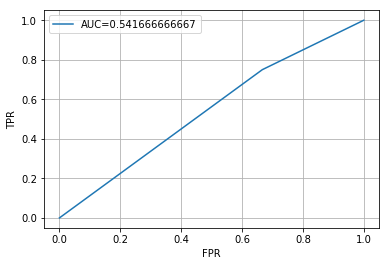

In [30]:
fpr, tpr, thresholds = roc_curve(y_eval, dt_eval_ypred, pos_label=1)
auc = np.trapz(tpr, fpr)
plt.plot(fpr, tpr, label="AUC=" + str(auc))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.grid()
plt.legend()
plt.show() 